# PFDA project

***

Weather data from [MET Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data).

In [359]:
# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
import seaborn as sns   # statistical plotting library

import pandas as pd         # import data analysis library
import geopandas as gpd     # geospatial stuff

# import predictive data analysis tools
from sklearn.linear_model import LinearRegression

import numpy as np  # array handling
import skunk        # for handling svg
import cairosvg     # converting svg, png, pdf
from IPython.display import Image   # display png


In [278]:
pd.set_option('display.colheader_justify', 'left') 

In [279]:
# data sources (monthly)
donegal_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly1575.csv" # Malin Head 2009-
cork_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly775.csv"     # Sherkin Island 2004-
dublin_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly3723.csv"  # Casement 1944-
galway_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly275.csv"   # Macehead 2003-
carlow_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly375.csv"   # Oak Park 2003-

First fetch the csv using a url above, and see what the metadata in the head of the csv looks like.

In [280]:
# Fetch the CSV file from the URL
response = requests.get(donegal_data_url)

# Check if the request was successful
if response.status_code == 200:
    # Split the content into lines
    lines = response.text.splitlines()

    # Print the first 22 lines
    for line in lines[:22]:
        print(line)
else:
    print(f"Failed to fetch the file. Status code: {response.status_code}")

Station Name: MALIN HEAD
Station Height: 20 M 
Latitude:55.372  ,Longitude: -7.339


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)             
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)	 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none 
clamt: -  Cloud amount
ind:   -  Indicator


Now to load each csv into its own dataframe. We can specify the number of rows to skip for each csv to skip the metadata header. They don't all have the same number of rows of metadata, so we need to check each one individually.

In [281]:
# load the data from the urls into DataFrames
donegal_df = pd.read_csv(donegal_data_url, skiprows=22, low_memory=False)
cork_df = pd.read_csv(cork_data_url, skiprows=16, low_memory=False)
dublin_df = pd.read_csv(dublin_data_url, skiprows=22, low_memory=False)
galway_df = pd.read_csv(galway_data_url, skiprows=16, low_memory=False)
carlow_df = pd.read_csv(carlow_data_url, skiprows=16, low_memory=False)

Check each dataframe is loaded correctly:

In [282]:
# print df head
donegal_df.head(5)
#cork_df.head(5)
#dublin_df.head(5)
#galway_df.head(5)
#carlow_df.head(5)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-may-1955 01:00,0,0.0,0,8.5,0,7.2,5.5,9.1,83,...,0,11,0,130,3,2,0.0,30000,40,7
1,01-may-1955 02:00,0,0.0,0,8.2,0,7.2,6.1,9.3,85,...,0,11,0,120,1,2,0.0,30000,100,6
2,01-may-1955 03:00,3,0.0,0,7.3,0,6.6,5.5,9.3,91,...,0,8,0,120,1,2,0.0,30000,220,5
3,01-may-1955 04:00,3,0.0,0,7.8,0,7.2,6.1,9.6,91,...,0,18,0,130,3,2,0.0,30000,90,7
4,01-may-1955 05:00,0,0.0,0,8.1,0,7.3,6.6,9.7,89,...,0,9,0,110,2,2,0.0,40000,90,7


In [283]:
# Convert the 'date' column to datetime format, specifying the current format in the csv
donegal_df['date'] = pd.to_datetime(donegal_df['date'], format='%d-%b-%Y %H:%M')

In [284]:
# have a look at dat column again
print(donegal_df['date'].head())

0   1955-05-01 01:00:00
1   1955-05-01 02:00:00
2   1955-05-01 03:00:00
3   1955-05-01 04:00:00
4   1955-05-01 05:00:00
Name: date, dtype: datetime64[ns]


Lets make a function to convert the date column in the other dataframes easily:

In [285]:
# creat function
def convert_date_column(df, column_name='date', date_format='%d-%b-%Y %H:%M'):
    """
    Convert the date column to datetime format in a DataFrame.
    """
    df[column_name] = pd.to_datetime(df[column_name], format=date_format)
    return df

We can create a dictionary of the location dataframes, and loop through each dataframe convertingt date columen to datetime format.

In [286]:
# Store DataFrames in a dictionary
dataframes = {
    'donegal_df': donegal_df,
    'cork_df': cork_df,
    'dublin_df': dublin_df,
    'galway_df': galway_df,
    'carlow_df': carlow_df
}

# Loop through the dictionary and apply the function
for name, df in dataframes.items():
    print(f"Converting date to datetime in: {name}...")
    dataframes[name] = convert_date_column(df)


Converting date to datetime in: donegal_df...
Converting date to datetime in: cork_df...
Converting date to datetime in: dublin_df...
Converting date to datetime in: galway_df...
Converting date to datetime in: carlow_df...


In [287]:
# check date column in one of the dfs
carlow_df.head(5)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,2003-08-01 01:00:00,-1,,4,,4,,,,,,7,,7,
1,2003-08-01 02:00:00,-1,,4,,4,,,,,,7,,7,
2,2003-08-01 03:00:00,-1,,4,,4,,,,,,7,,7,
3,2003-08-01 04:00:00,-1,,4,,4,,,,,,7,,7,
4,2003-08-01 05:00:00,-1,,4,,4,,,,,,7,,7,


Now to select only the date and windspeed columns from each dataframe. We rename wdsp columns to include location name, for combining them later into one dataframe. We need to differentiate each column for its location.

In [288]:
# create new dfs with only date and wdsp, and rename the wdsp column to have location name
donegal_wdsp_df = donegal_df[['date', 'wdsp']].copy()
donegal_wdsp_df.rename(columns={'wdsp': 'wdsp_donegal'}, inplace=True)

cork_wdsp_df = cork_df[['date', 'wdsp']].copy()
cork_wdsp_df.rename(columns={'wdsp': 'wdsp_cork'}, inplace=True)

dublin_wdsp_df = dublin_df[['date', 'wdsp']].copy()
dublin_wdsp_df.rename(columns={'wdsp': 'wdsp_dublin'}, inplace=True)

galway_wdsp_df = galway_df[['date', 'wdsp']].copy()
galway_wdsp_df.rename(columns={'wdsp': 'wdsp_galway'}, inplace=True)

carlow_wdsp_df = carlow_df[['date', 'wdsp']].copy()
carlow_wdsp_df.rename(columns={'wdsp': 'wdsp_carlow'}, inplace=True)

In [289]:
# check one of the new dataframes
donegal_wdsp_df

,date,wdsp_donegal
0,1955-05-01 01:00:00,11
1,1955-05-01 02:00:00,11
2,1955-05-01 03:00:00,8
3,1955-05-01 04:00:00,18
4,1955-05-01 05:00:00,9
...,...,...
609283,2024-10-31 20:00:00,12
609284,2024-10-31 21:00:00,13
609285,2024-10-31 22:00:00,13
609286,2024-10-31 23:00:00,14


Merging dataframes:

- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#merge

This only works for two dataframes, For multiple dataframes, we have to call it several times.

In [290]:
# merge the datasets on the date columns
combined_wdsp_df = donegal_wdsp_df.merge(
    cork_wdsp_df, on=['date'], how='inner'
).merge(
    dublin_wdsp_df, on=['date'], how='inner'
).merge(
    galway_wdsp_df, on=['date'], how='inner'
).merge(
    carlow_wdsp_df, on=['date'], how='inner'
)

In [291]:
# have a lok at the new combined dataframe
combined_wdsp_df

,date,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow
0,2004-04-30 01:00:00,29,,4,17,7
1,2004-04-30 02:00:00,27,,6,19,7
2,2004-04-30 03:00:00,28,,6,14,7
3,2004-04-30 04:00:00,28,,6,19,8
4,2004-04-30 05:00:00,29,,6,21,8
...,...,...,...,...,...,...
179755,2024-10-31 20:00:00,12,2,8,11,5
179756,2024-10-31 21:00:00,13,3,9,11,3
179757,2024-10-31 22:00:00,13,3,8,11,2
179758,2024-10-31 23:00:00,14,3,8,12,3


Clean data a bit, theres going to be some missing rows etc.

In [292]:
# replace empty strings with NaN
#df = df.replace(["", " ", "NA", "null"], np.nan)

In [293]:
# check how many missing entries in each column
combined_wdsp_df.isna().sum()


date            0
wdsp_donegal    0
wdsp_cork       0
wdsp_dublin     0
wdsp_galway     0
wdsp_carlow     0
dtype: int64

In [294]:
# drop empties
combined_wdsp_df.dropna(inplace=True)

In [295]:
# check missing entries again
combined_wdsp_df.isna().sum()

date            0
wdsp_donegal    0
wdsp_cork       0
wdsp_dublin     0
wdsp_galway     0
wdsp_carlow     0
dtype: int64

In [296]:
# view the first row in the dataframe
combined_wdsp_df.iloc[0]

date            2004-04-30 01:00:00
wdsp_donegal                     29
wdsp_cork                          
wdsp_dublin                       4
wdsp_galway                      17
wdsp_carlow                       7
Name: 0, dtype: object

In [297]:
# view datatypes
combined_wdsp_df.dtypes

date            datetime64[ns]
wdsp_donegal            object
wdsp_cork               object
wdsp_dublin             object
wdsp_galway             object
wdsp_carlow             object
dtype: object

The windspeed column isnt numeric type. We need to convert entire dataframe to numeric before working with the data.

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

We can use a lambda function to exclude the date column.

- https://www.w3schools.com/python/python_lambda.asp

In [298]:
# convert to all columns to numeric
#combined_wdsp_df = combined_wdsp_df.apply(pd.to_numeric, errors='coerce')

# Convert all columns to numeric, except the 'date' column
combined_wdsp_df = combined_wdsp_df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name != 'date' else x)


In [299]:
# check df again
combined_wdsp_df.dtypes

date            datetime64[ns]
wdsp_donegal           float64
wdsp_cork              float64
wdsp_dublin            float64
wdsp_galway            float64
wdsp_carlow            float64
dtype: object

In [300]:
# display new combined windspeed df
combined_wdsp_df

,date,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow
0,2004-04-30 01:00:00,29.0,NaN,4.0,17.0,7.0
1,2004-04-30 02:00:00,27.0,NaN,6.0,19.0,7.0
2,2004-04-30 03:00:00,28.0,NaN,6.0,14.0,7.0
3,2004-04-30 04:00:00,28.0,NaN,6.0,19.0,8.0
4,2004-04-30 05:00:00,29.0,NaN,6.0,21.0,8.0
...,...,...,...,...,...,...
179755,2024-10-31 20:00:00,12.0,2.0,8.0,11.0,5.0
179756,2024-10-31 21:00:00,13.0,3.0,9.0,11.0,3.0
179757,2024-10-31 22:00:00,13.0,3.0,8.0,11.0,2.0
179758,2024-10-31 23:00:00,14.0,3.0,8.0,12.0,3.0


In [301]:
# Extract the year from date columne, and create a new column
combined_wdsp_df['year'] = combined_wdsp_df['date'].dt.year


In [302]:
combined_wdsp_df


,date,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow,year
0,2004-04-30 01:00:00,29.0,NaN,4.0,17.0,7.0,2004
1,2004-04-30 02:00:00,27.0,NaN,6.0,19.0,7.0,2004
2,2004-04-30 03:00:00,28.0,NaN,6.0,14.0,7.0,2004
3,2004-04-30 04:00:00,28.0,NaN,6.0,19.0,8.0,2004
4,2004-04-30 05:00:00,29.0,NaN,6.0,21.0,8.0,2004
...,...,...,...,...,...,...,...
179755,2024-10-31 20:00:00,12.0,2.0,8.0,11.0,5.0,2024
179756,2024-10-31 21:00:00,13.0,3.0,9.0,11.0,3.0,2024
179757,2024-10-31 22:00:00,13.0,3.0,8.0,11.0,2.0,2024
179758,2024-10-31 23:00:00,14.0,3.0,8.0,12.0,3.0,2024


In [303]:
# Group by 'date' and calculate the mean temperature for each day
mean_yearly_wdsp_df = combined_wdsp_df.groupby('year').mean().reset_index()

# If needed, filter only the columns you are interested in (e.g., windspeed columns)
mean_yearly_wdsp_df = mean_yearly_wdsp_df[['year', 'wdsp_donegal', 'wdsp_cork', 'wdsp_dublin', 'wdsp_galway', 'wdsp_carlow']]


In [304]:
# check df 
mean_yearly_wdsp_df

,year,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow
0,2004,14.171269,11.644557,9.402677,14.794077,7.116440
1,2005,13.199201,12.110753,9.627283,13.683854,7.600069
2,2006,14.986187,12.396114,9.749772,14.253881,7.413174
3,2007,14.611986,11.927283,9.304566,14.254338,7.357306
4,2008,16.156876,12.183454,10.423725,14.404258,7.742942
5,2009,13.429795,12.456735,10.032877,14.622945,7.587215
6,2010,13.607192,10.553881,8.040639,11.979452,6.369406
7,2011,14.940411,12.598516,10.357991,15.387443,7.615297
8,2012,14.808288,12.300774,9.442281,14.286418,7.132969
9,2013,15.485959,12.630551,9.769749,14.840953,7.512501


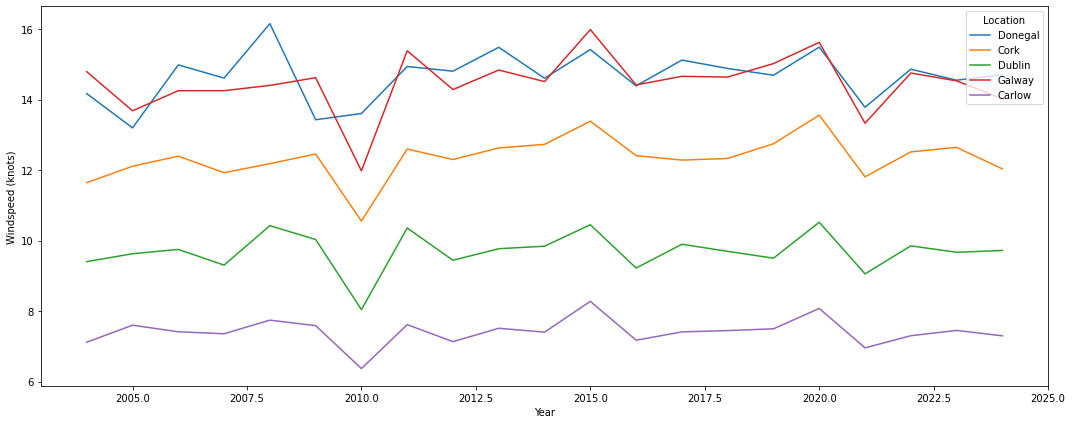

In [305]:
# plot line using seaborn
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=mean_yearly_wdsp_df, x='year', y='wdsp_donegal', label='Donegal')
sns.lineplot(data=mean_yearly_wdsp_df, x='year', y='wdsp_cork', label='Cork')
sns.lineplot(data=mean_yearly_wdsp_df, x='year', y='wdsp_dublin', label='Dublin')
sns.lineplot(data=mean_yearly_wdsp_df, x='year', y='wdsp_galway', label='Galway')
sns.lineplot(data=mean_yearly_wdsp_df, x='year', y='wdsp_carlow', label='Carlow')

# decorate the plot
plt.xlabel("Year")
plt.ylabel("Windspeed (knots)")
#plt.title(f"wi")
plt.legend(title='Location', loc='upper right')

plt.tight_layout()

### Predictive Stuff

scikit learn needs numeric columns, convert datetime to fractional years first.

In [306]:
# Extract year and day of year from datetime
combined_wdsp_df['year'] = df['date'].dt.year
combined_wdsp_df['day_of_year'] = df['date'].dt.dayofyear

combined_wdsp_df

,date,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow,year,day_of_year
0,2004-04-30 01:00:00,29.0,NaN,4.0,17.0,7.0,2003,213
1,2004-04-30 02:00:00,27.0,NaN,6.0,19.0,7.0,2003,213
2,2004-04-30 03:00:00,28.0,NaN,6.0,14.0,7.0,2003,213
3,2004-04-30 04:00:00,28.0,NaN,6.0,19.0,8.0,2003,213
4,2004-04-30 05:00:00,29.0,NaN,6.0,21.0,8.0,2003,213
...,...,...,...,...,...,...,...,...
179755,2024-10-31 20:00:00,12.0,2.0,8.0,11.0,5.0,2024,32
179756,2024-10-31 21:00:00,13.0,3.0,9.0,11.0,3.0,2024,32
179757,2024-10-31 22:00:00,13.0,3.0,8.0,11.0,2.0,2024,32
179758,2024-10-31 23:00:00,14.0,3.0,8.0,12.0,3.0,2024,32


In [307]:
# Calculate fractional year
combined_wdsp_df['fractional_year'] = combined_wdsp_df['year'] + (combined_wdsp_df['day_of_year'] - 1) / 365

combined_wdsp_df

,date,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow,year,day_of_year,fractional_year
0,2004-04-30 01:00:00,29.0,NaN,4.0,17.0,7.0,2003,213,2003.580822
1,2004-04-30 02:00:00,27.0,NaN,6.0,19.0,7.0,2003,213,2003.580822
2,2004-04-30 03:00:00,28.0,NaN,6.0,14.0,7.0,2003,213,2003.580822
3,2004-04-30 04:00:00,28.0,NaN,6.0,19.0,8.0,2003,213,2003.580822
4,2004-04-30 05:00:00,29.0,NaN,6.0,21.0,8.0,2003,213,2003.580822
...,...,...,...,...,...,...,...,...,...
179755,2024-10-31 20:00:00,12.0,2.0,8.0,11.0,5.0,2024,32,2024.084932
179756,2024-10-31 21:00:00,13.0,3.0,9.0,11.0,3.0,2024,32,2024.084932
179757,2024-10-31 22:00:00,13.0,3.0,8.0,11.0,2.0,2024,32,2024.084932
179758,2024-10-31 23:00:00,14.0,3.0,8.0,12.0,3.0,2024,32,2024.084932


In [308]:
# check for empties
combined_wdsp_df.isna().sum()

date                 0
wdsp_donegal        52
wdsp_cork          404
wdsp_dublin          4
wdsp_galway        462
wdsp_carlow        794
year                 0
day_of_year          0
fractional_year      0
dtype: int64

In [309]:
# remove empties
combined_wdsp_df.dropna(inplace=True)

In [310]:
# check empties again
combined_wdsp_df.isna().sum()

date               0
wdsp_donegal       0
wdsp_cork          0
wdsp_dublin        0
wdsp_galway        0
wdsp_carlow        0
year               0
day_of_year        0
fractional_year    0
dtype: int64

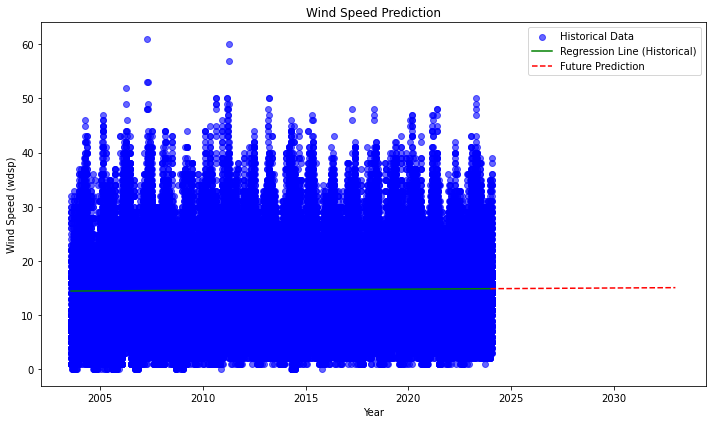

In [311]:
# select variables to plot
X = combined_wdsp_df[['fractional_year']]
y = combined_wdsp_df['wdsp_donegal']

# train the linear regression model
model = LinearRegression()
model.fit(X, y)

# predict wind speeds for historical data
historical_predictions = model.predict(X)

# predict future wind speeds 10 years ahead
future_years = pd.DataFrame({'fractional_year': np.arange(2024, 2034)})  # adds future years into fractional_year column
future_predictions = model.predict(future_years)

# plot the results
plt.figure(figsize=(10, 6))

# plot historical data
plt.scatter(X, y, label='Historical Data', color='blue', alpha=0.6)

# plot regression line
plt.plot(X, historical_predictions, color='green', label='Regression Line (Historical)')

# plot future predictions

plt.plot(future_years, future_predictions, color='red', linestyle='--', label='Future Prediction')

# Decorate the plot
plt.xlabel('Year')
plt.ylabel('Wind Speed (wdsp)')
plt.title('Wind Speed Prediction')
plt.legend()
plt.tight_layout()

In [312]:
# check if the future years column updated
future_years

,fractional_year
0,2024
1,2025
2,2026
3,2027
4,2028
5,2029
6,2030
7,2031
8,2032
9,2033


### Windfarm Locations

Data from https://data.gov.ie/dataset/wind-farms-in-ireland

Plot map of Ireland first then plot windfarm location data on top.

In [313]:
# define the url to windfarm location data
#windfarm_url = "https://seaiopendata.blob.core.windows.net/wind/WindFarmsJune2022_ESPG3857.zip"

# define the path to the downloaded shapefile
windfarm_shp_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"

Plot the map. Geopandas is an open-source library for plotting geospatial data.

- https://geopandas.org/en/stable/about.html

A compass on the map would look nice. Needs to be svg (vector). Found a library called skunk. 

- https://github.com/whitead/skunk

It allows use of svg with matplotlib.

Ciaro is a command-line tool that can also be used in python, allowing for conversion between svg, png, pdf etc.

- https://cairosvg.org/documentation/

In [360]:
# Load the Ireland shapefile
main_map_path = "./data/Ireland_Shapefiles_ITM/Ireland_CountyBoundaries_ITM.shp"
main_map = gpd.read_file(main_map_path)
print(f"Ireland shapefile CRS: {main_map.crs}")

# Load the windfarm locations shapefile
locations_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"
locations = gpd.read_file(locations_path)
print(f"Windfarm locations CRS: {locations.crs}")

# Convert both shapefiles to EPSG:4326
main_map = main_map.to_crs("EPSG:4326")
locations = locations.to_crs("EPSG:4326")
print(f"Ireland shapefile CRS after conversion: {main_map.crs}")
print(f"Windfarm locations CRS after conversion: {locations.crs}")

# Set up figure, axis
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor('lightblue')  # Set background color

# Plot the Ireland shapefile
main_map.plot(ax=ax, color='#083527', edgecolor='black')

# Plot windfarm locations
locations.plot(ax=ax, color='orange', marker='o', label='Wind Farm')

# Add title, legend, labels
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.1))
plt.title("Wind Farm Locations, Ireland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Insert compass SVG in the top-left using skunk
box_compass = skunk.Box(125, 125, 'sk1')  # Create a skunk box for the compass
ab_compass = AnnotationBbox(box_compass, (0.18, 0.86),  # Position in top-left
                             xycoords='axes fraction',
                             boxcoords='offset points',
                             frameon=False)
ax.add_artist(ab_compass)

# Insert the SVGs into skunk
svg = skunk.insert(
    {
        'sk1': './data/compass.svg'  # Path to the compass.svg
    })

# Display the SVG in Jupyter Notebook
skunk.display(svg)

# Do not display the plot
plt.close(fig)  # This will prevent the plot from displaying in Jupyter Notebook

# Save the figure if needed
#fig.savefig("test.png")

# save map to pdf and png
cairosvg.svg2pdf(bytestring=svg, write_to='./data/map_with_compass.pdf')
cairosvg.svg2png(bytestring=svg, write_to='./data/map_with_compass.png')

# Convert SVG to PNG
cairosvg.svg2png(svg, write_to='./data/map_with_compass.png')
print("Saved as map_with_compass.png in data folder")

Ireland shapefile CRS: EPSG:2157
Windfarm locations CRS: EPSG:3857
Ireland shapefile CRS after conversion: EPSG:4326
Windfarm locations CRS after conversion: EPSG:4326


Saved as map_with_compass.png in data folder


The skunk svg doesn't render correctly in Jupyter, so it was saved as png and displayed below.

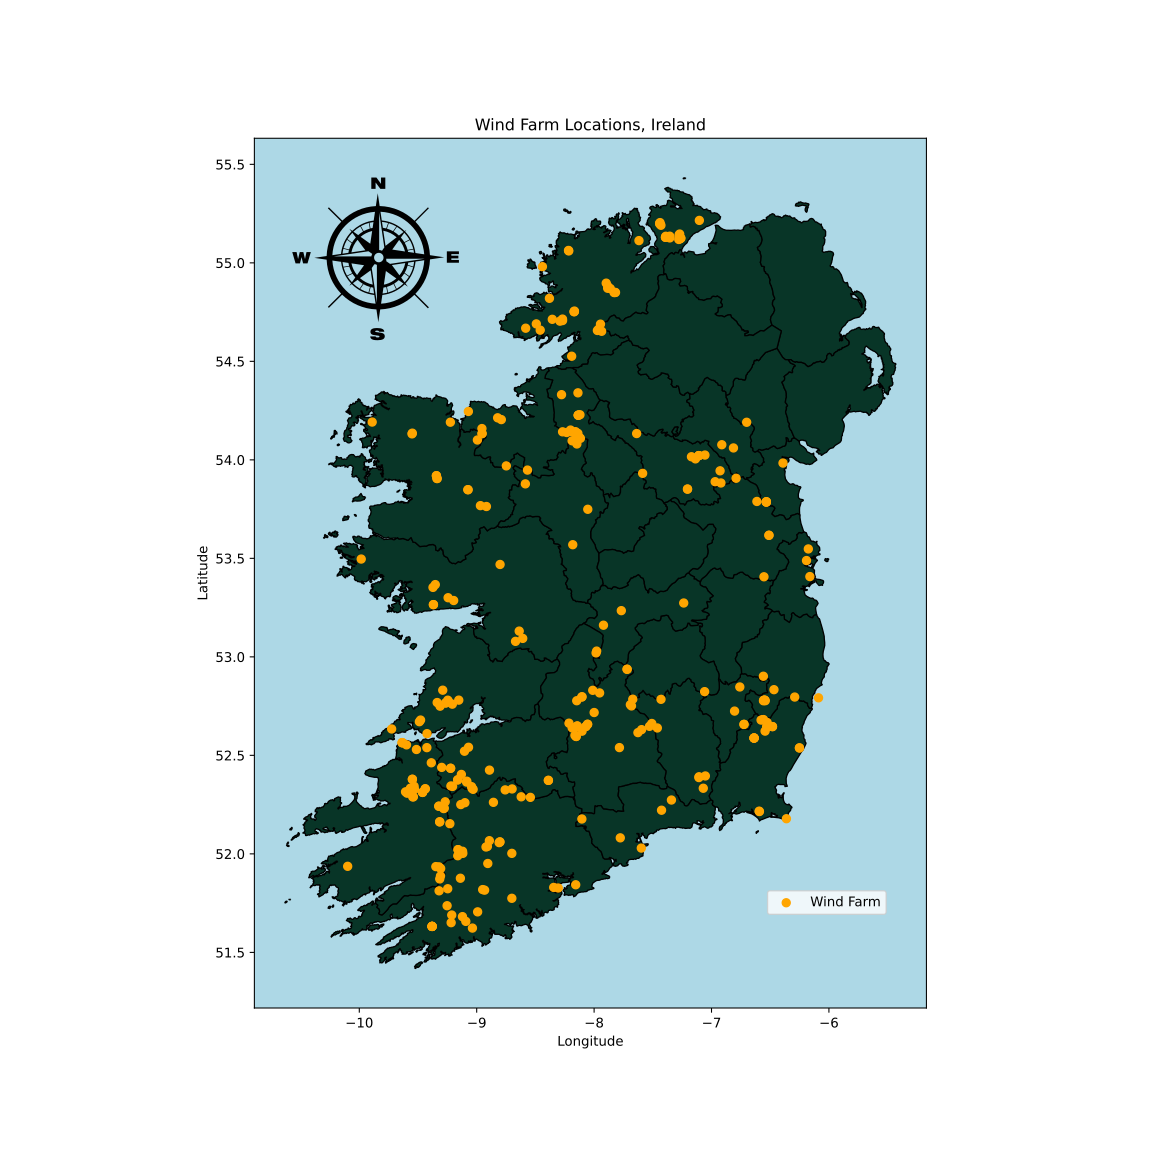

In [ ]:
# Display the PNG file
Image(filename='./data/map_with_compass.png')

***

### END